In [1]:
import os
import pathlib

os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [2]:
import torch
import wandb
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from ebms.data import ToyDataGenerator
from ebms.models import MLP
from ebms.samplers import LangevinMC, HamiltonianMC
from ebms.utils.plotting import visualize_samples
from ebms.losses import (
    MaximumLikelihoodMCMCLoss,
    ScoreMatchingLoss,
    DenoisingScoreMatchingLoss,
    SlicedScoreMatchingLoss,
    NoiseContrastiveEstimationLoss,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

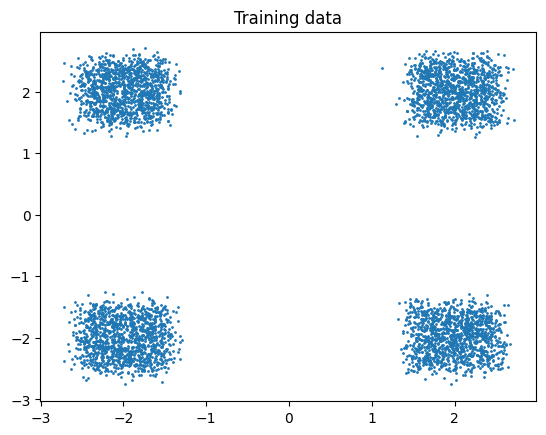

In [3]:
train_data = ToyDataGenerator.generate("4squares", 5000)
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_data), batch_size=8, shuffle=True, num_workers=8
)

plt.scatter(train_data[:, 0], train_data[:, 1], s=1)
plt.title("Training data")
plt.show()

wandb: Currently logged in as: 4002tsa. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


  0%|          | 0/625 [00:00<?, ?it/s]

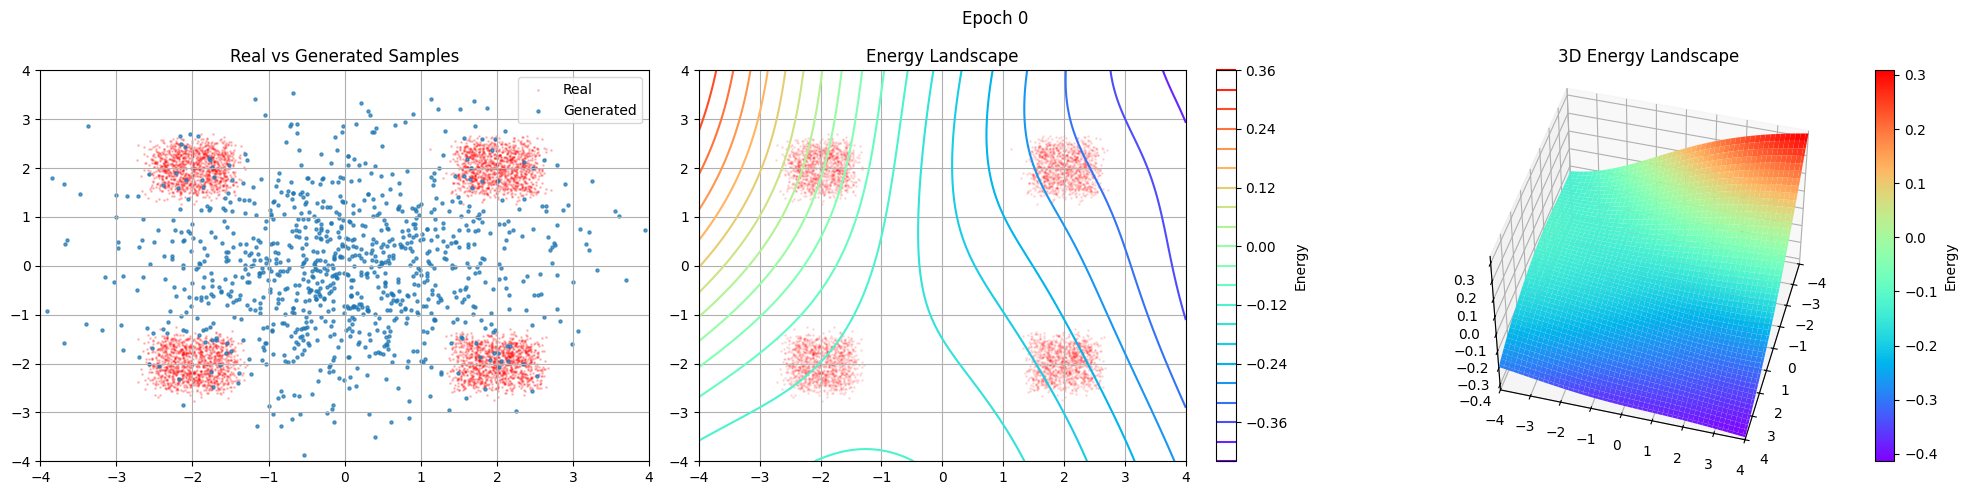

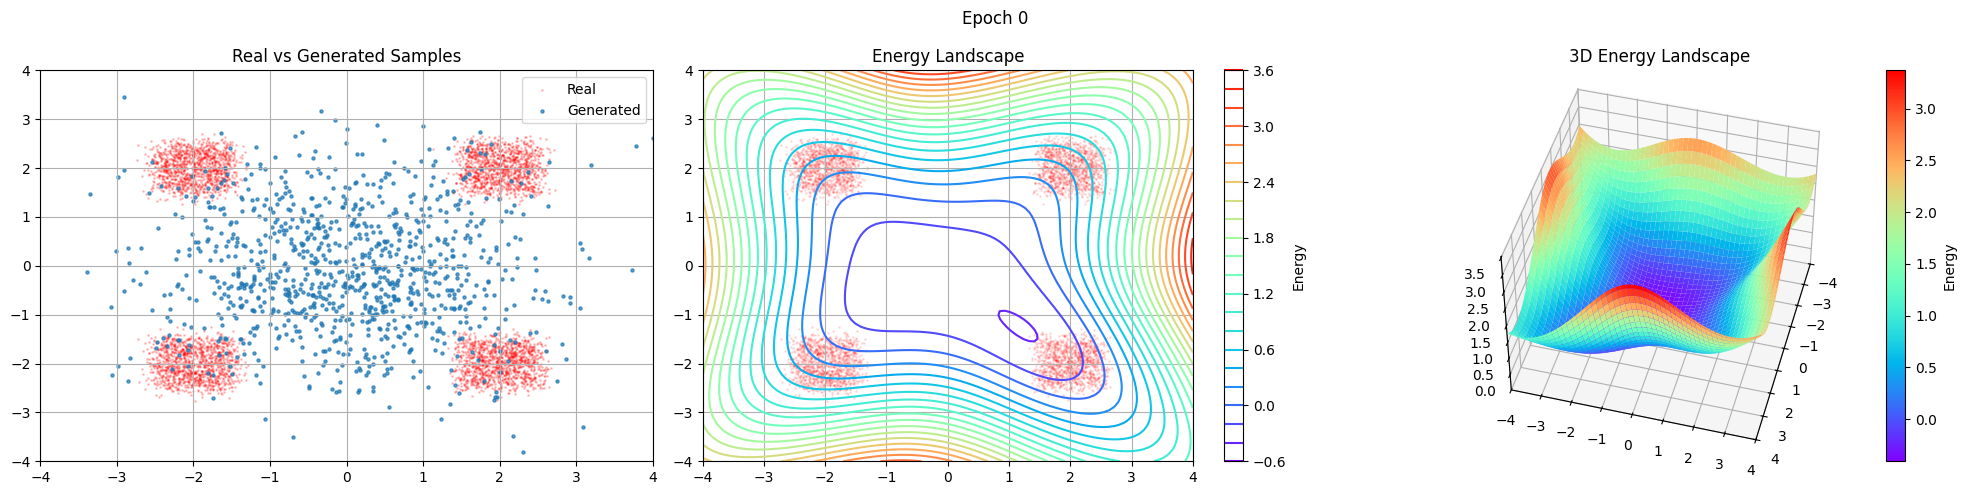

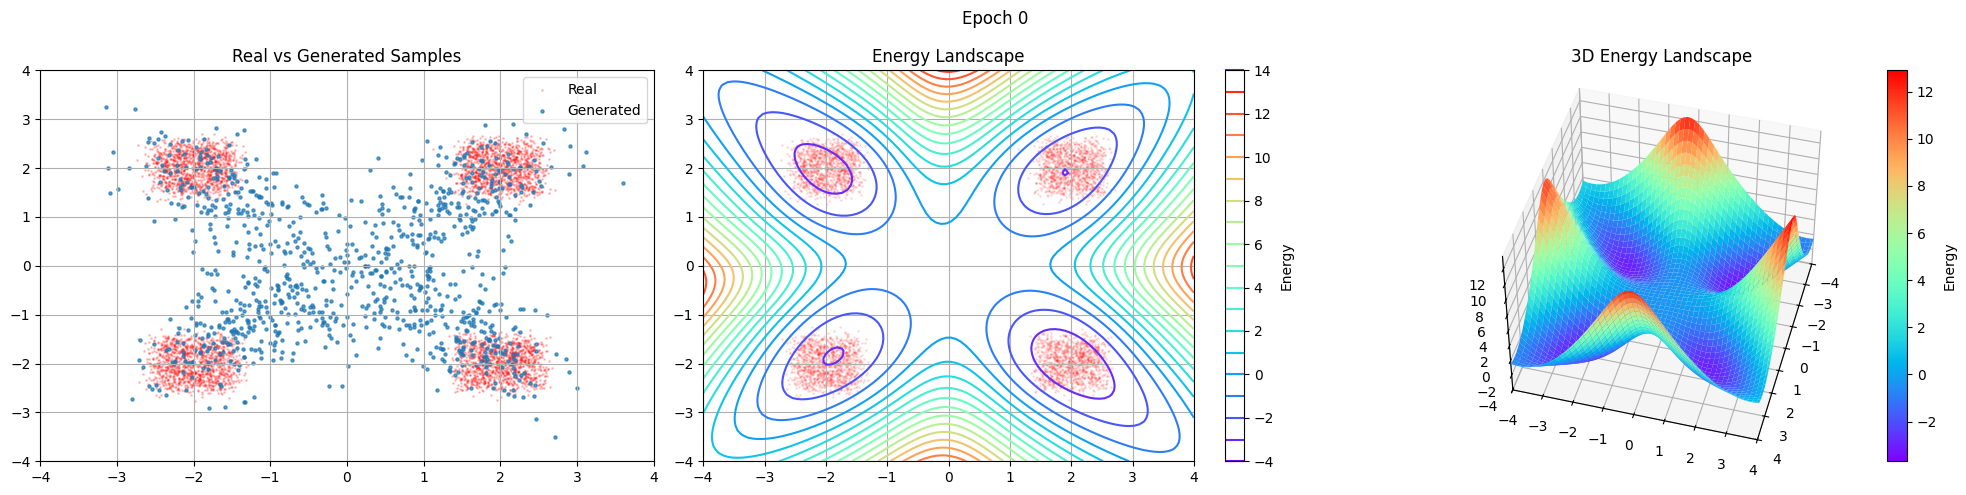

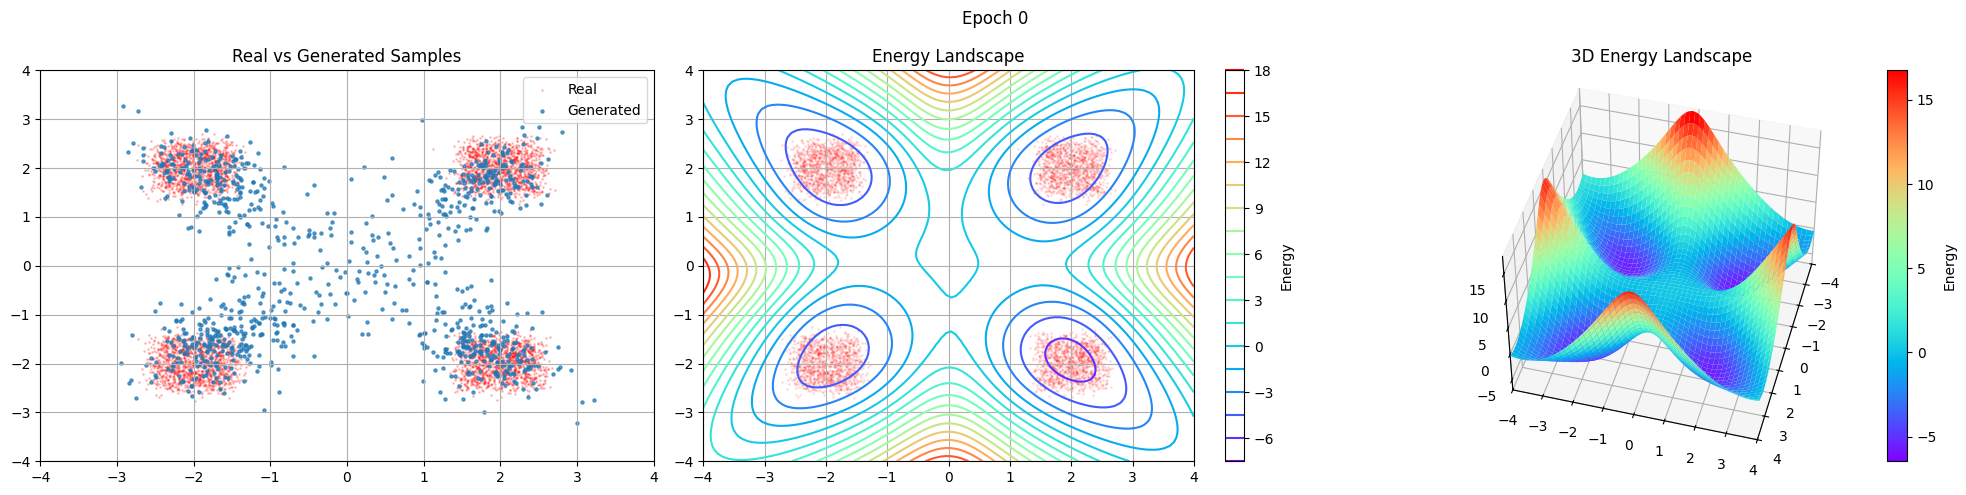

  0%|          | 0/625 [00:00<?, ?it/s]

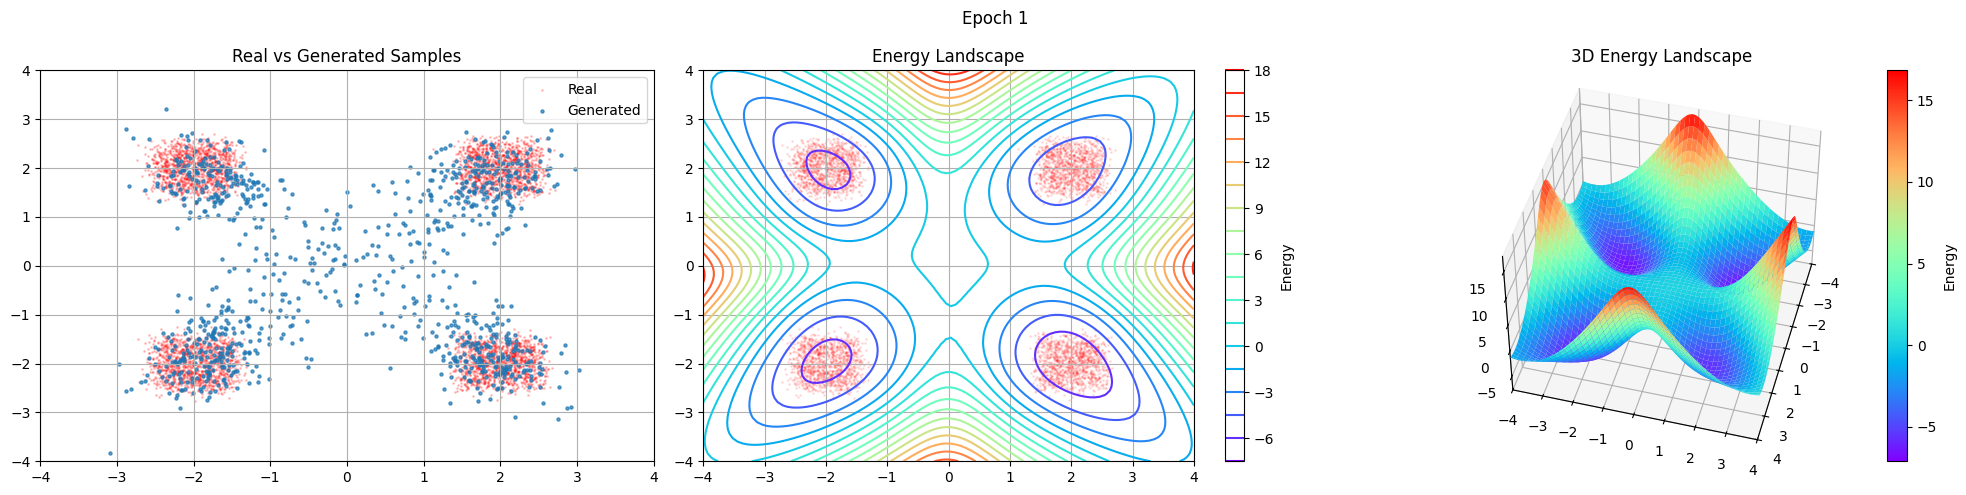

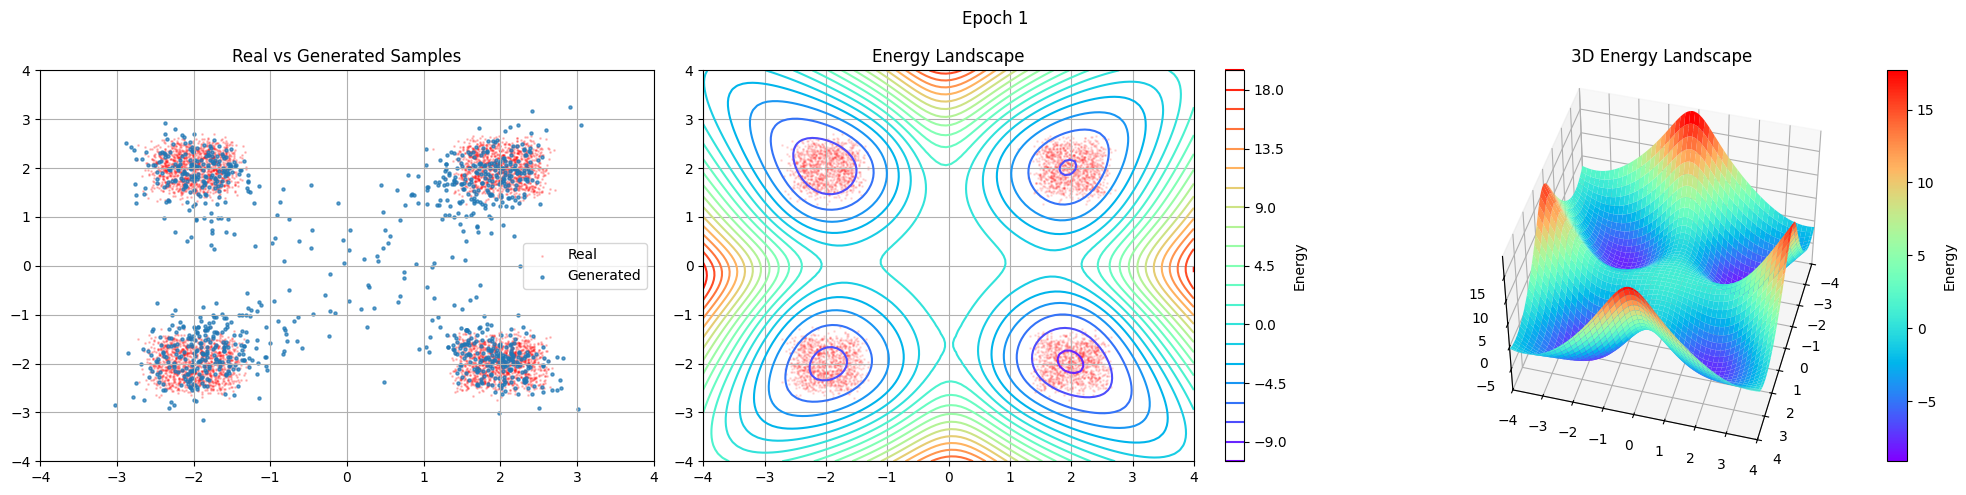

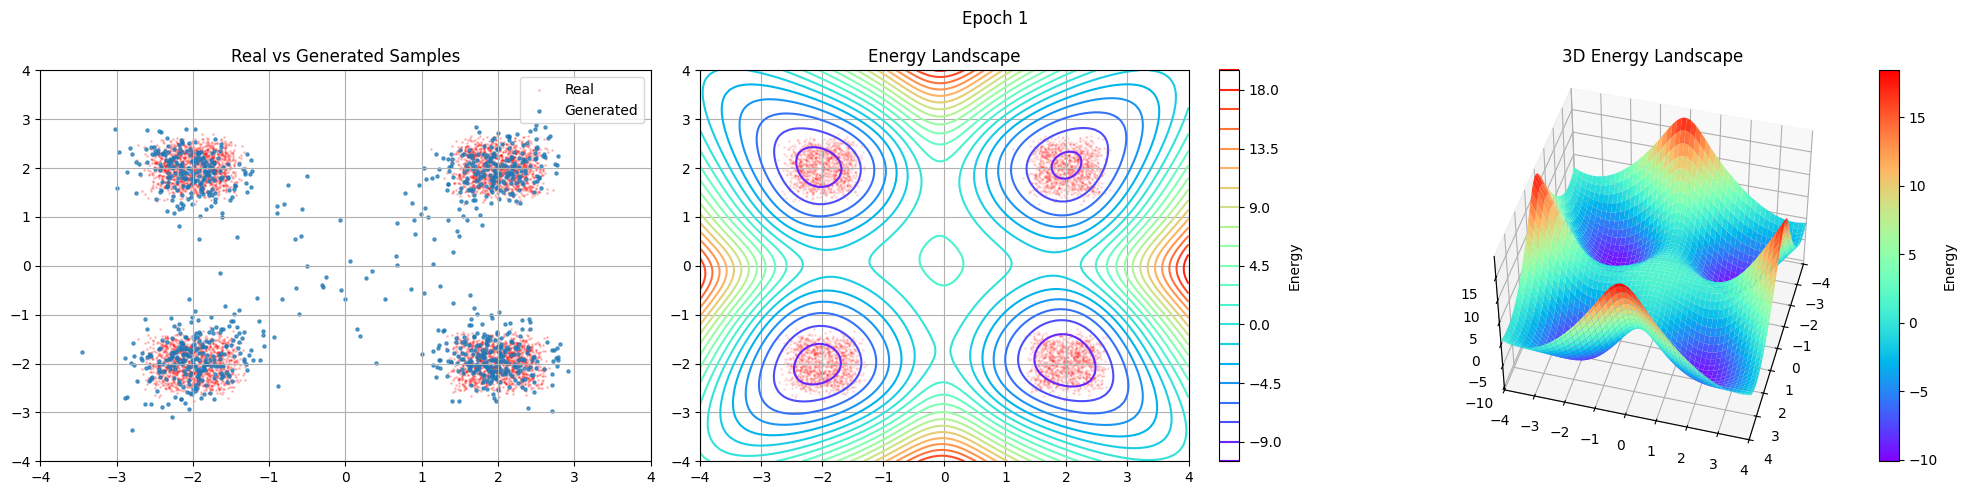

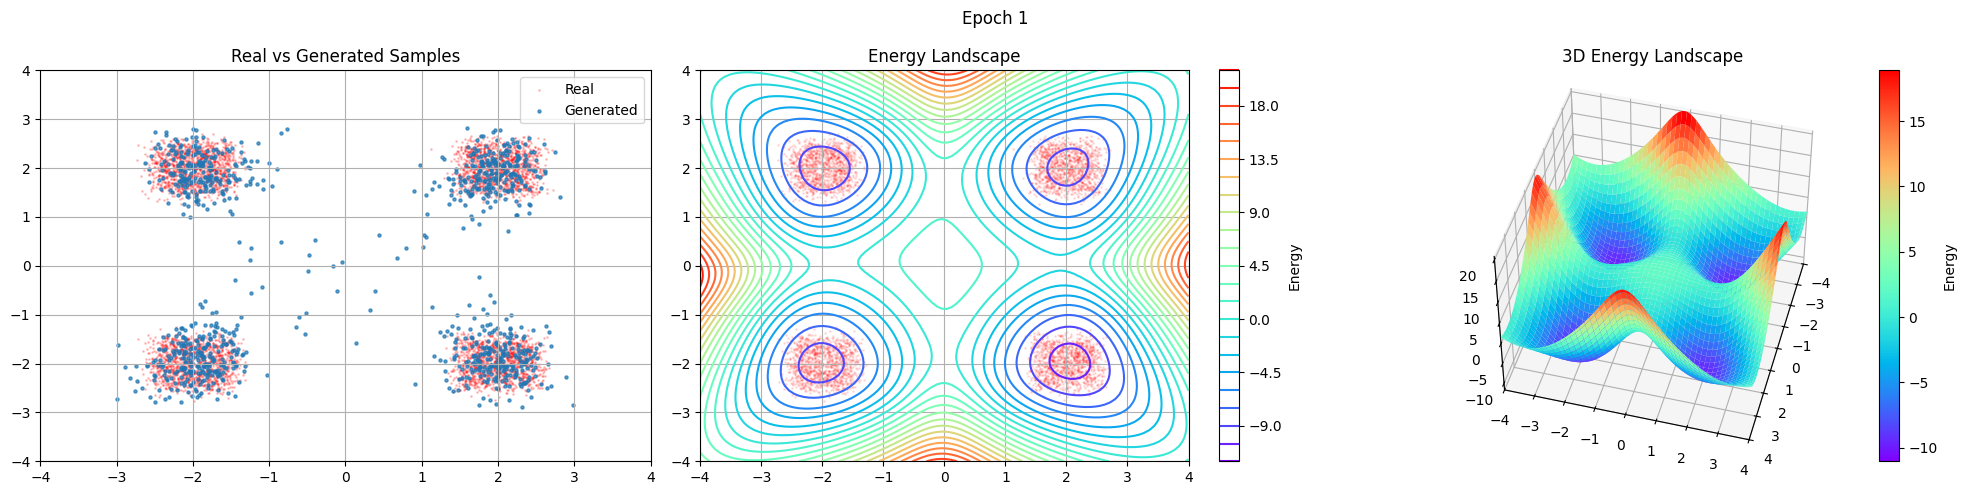

In [4]:
model = MLP(in_dim=2, hidden_dim=32, out_dim=1).to(device)

# sampler = LangevinMC(stepsize=0.1)
sampler = HamiltonianMC(step_size=0.01, leapfrog_steps=10, mass=1.0)

# loss_fn = MaximumLikelihoodMCMCLoss(
#     sampler=sampler, alpha=0.4, buffer_size=10000, n_sampler_steps=50, device=device
# )
loss_fn = ScoreMatchingLoss()
# loss_fn = DenoisingScoreMatchingLoss(sigma=0.1)
# loss_fn = SlicedScoreMatchingLoss()
# loss_fn = NoiseContrastiveEstimationLoss()

wandb.init(project="ebm-training")

NUM_EPOCHS = 2
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(NUM_EPOCHS):
    for batch_idx, (pos_x,) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()
        pos_x = pos_x.to(device)

        loss = loss_fn(model, pos_x)
        wandb.log({"loss": loss.item()})
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if batch_idx % 200 == 0:
            fig = visualize_samples(
                model,
                sampler,
                train_data,
                num_generated_samples=1000,
                num_sampling_steps=100,
                title=f"Epoch {epoch}",
            )
            wandb.log({"samples": wandb.Image(fig)})

    plt.show()

In [5]:
wandb.finish()